This routine is provided as an example on how to correct conductivity data
collected from an RBRargo3 Argo float for compressibility errors.

It relies on the CSV file listing the appropriate coefficients:
https://github.com/ArgoDMQC/RBRargo_DMQC/blob/main/RBRargo3_compressibility_table.csv

As well as on an example profile from:
https://fleetmonitoring.euro-argo.eu/float/6903078
    

#### Import required modules

In [1]:
from RBRargo3_celltm import RBRargo3_celltm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gsw
%matplotlib inline

#### Example code

Uses a sample file retrieved from euro-argo

https://fleetmonitoring.euro-argo.eu/float/6903078

The sample file is a CSV file with the data from the 1nd profile for WMO6903078

In [2]:
#Load the CSV file with example data
argo = pd.read_csv("../../test_data/6903078_testdata.csv")
argo.columns = ["PLATFORM_CODE", "DATEYYYYMMDDTHHMISSZ", "DATE_QC", "LATITUDEdegree_north", "LONGITUDEdegree_east", "POSITION_QC", "PRESdecibar", "PRES_QC", "PSALpsu", "PSAL_QC", "TEMPdegree_Celsius", "TEMP_QC", "PRES_ADJUSTEDdecibar", "PRES_ADJUSTED_QC", "TEMP_ADJUSTEDdegree_Celsius", "TEMP_ADJUSTED_QC", "PSAL_ADJUSTEDpsu", "PSAL_ADJUSTED_QC", "TEMP_CNDCdegree_Celsius", "TEMP_CNDC_QC"];
argo.astype = ["float64", "categorical", "float64", "float64", "float64", "float64", "float64", "float64", "float64", "double", "double", "double", "double", "double", "double", "double", "double", "double", "double", "double"]

#Simplify variables
lon = argo['LONGITUDEdegree_east'][0]
lat = argo['LATITUDEdegree_north'][0]
PRES = argo['PRESdecibar'].to_numpy()
TEMP = argo['TEMPdegree_Celsius'].to_numpy()
PSAL = argo['PSALpsu'].to_numpy()
TEMP_CNDC = argo['TEMP_CNDCdegree_Celsius'].to_numpy()

#Infers elptime using a nominal ascent rate of 10 cm/s
asentRate = 0.10 
elptime = (PRES.max() - PRES)/ asentRate

#Sort the data chronologically
I = np.argsort(elptime)
elptime = elptime[I]
PRES = PRES[I]
TEMP = TEMP[I]
PSAL = PSAL[I]
TEMP_CNDC = TEMP_CNDC[I]

#Compute additional variables using GSW TEOS-10
COND = gsw.C_from_SP(PSAL, TEMP, PRES)
SA = gsw.SA_from_SP(PSAL, PRES, lon, lat)
CT = gsw.CT_from_t(SA, TEMP, PRES)
sig = gsw.sigma0(SA, CT)

#Apply thermal inertia corrections
TEMP_celltm = RBRargo3_celltm(TEMP, PRES, TEMP_CNDC, elptime)
PSAL_ADJUSTED_CTM = gsw.SP_from_C(COND, TEMP_celltm, PRES)

#Compute additional variables using GSW TEOS-10
SAcor = gsw.SA_from_SP(PSAL_ADJUSTED_CTM, PRES, lon, lat)
CTcor = gsw.CT_from_t(SAcor, TEMP, PRES)
sigcor = gsw.sigma0(SAcor, CTcor)


Plot the difference in conductivity before and after the correction as a function of pressure 

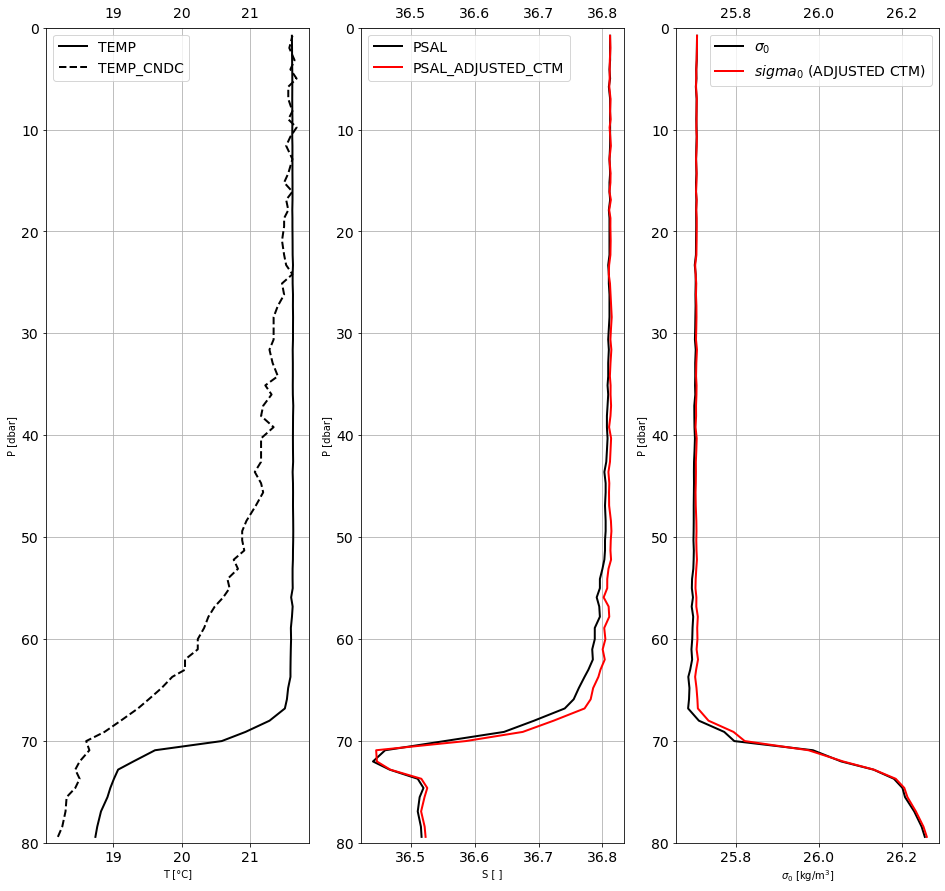

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(16, 15))
axs[0].plot(TEMP[PRES<80], PRES[PRES<80], 'k', linewidth=2)
axs[0].plot(TEMP_CNDC[PRES<80], PRES[PRES<80], '--k', linewidth=2)
axs[0].invert_yaxis()
axs[0].grid(True)
axs[0].set_ylim([80, 0])
axs[0].set_ylabel('P [dbar]')
axs[0].set_xlabel('T [°C]')
#axs[0].autoscale(enable=True, axis='x', tight=True)
axs[0].legend(['TEMP', 'TEMP_CNDC'], loc='upper left', fontsize=14)

axs[1].plot(PSAL[PRES<80], PRES[PRES<80], 'k', linewidth=2)
axs[1].plot(PSAL_ADJUSTED_CTM[PRES<80], PRES[PRES<80], 'r', linewidth=2)
axs[1].invert_yaxis()
axs[1].grid(True)
axs[1].set_ylim([80, 0])
axs[1].set_ylabel('P [dbar]')
axs[1].set_xlabel('S [ ]')
axs[1].legend(['PSAL', 'PSAL_ADJUSTED_CTM'], loc='upper left', fontsize=14)

axs[2].plot(sig[PRES<80], PRES[PRES<80], 'k', linewidth=2)
axs[2].plot(sigcor[PRES<80], PRES[PRES<80], 'r', linewidth=2)
axs[2].invert_yaxis()
axs[2].grid(True)
axs[2].set_ylim([80,0])
axs[2].set_ylabel('P [dbar]')
axs[2].set_xlabel(r'$\sigma_0$ [kg/m$^3$]')
axs[2].legend([r'$\sigma_0$',r'$sigma_0$ (ADJUSTED CTM)'], loc= 'upper right', fontsize = 14)

for i in range(3):
    axs[i].tick_params(labelsize=14, labeltop=True)

fig.set_facecolor('w')
